In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn

In [3]:
glove=Embeddings('glove-wiki-gigaword-50')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
np.isnan(vectors).any()

False

In [6]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 611739.40it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [7]:
#Gender specific vocabulary:
gender_specific=[]
female_vocab=[]
male_vocab=[]
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific=female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [90]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], [
            'her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [9]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]


In [91]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

In [128]:
import itertools

def get_pairs_from_equalizing_sets(def_sets):
    data = {i: v for i, v in enumerate(def_sets)}
    #print(data)
    pairs = []
    for _, values in data.items():
	    #Get all possible combinations of pairs
	    for v1 in values:
		    for v2 in values:
                           s = set([v1, v2])
                           if(len(s) > 1 and not (v1 in pairs and v2 in pairs)):
                                pairs.append([v1, v2])
                      #     if (v1 in pairs or v2 in pairs):
                       #          print(v1,v2)
	#Remove duplicates
    pairs.sort()
    cleaned_pairs=list(k for k, _ in itertools.groupby(pairs))
    return cleaned_pairs

In [139]:
from itertools import product


def get_pairs(p1, p2):
    pairs = set()
    for v1, v2 in product(p1, p2):
        for val1, val2 in product(v1, v2):
            pairs.add((val1, val2))
    return list(pairs)


In [92]:
equalizing_lists['race']=get_pairs_from_equalizing_sets(def_sets['race'])


In [141]:
equalizing_lists['intersection']=get_pairs(def_sets['gender'], def_sets['race'])


#### Gender

In [35]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


#### Race

In [94]:
deb_vect_race, deb_vocab_race, deb_word2idx_race,deb_dict_race = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['race'], 
                             def_set_race,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 20
Running PCA with 1 components


#### Joint

In [142]:
deb_vect_joined, deb_vocab_joined, deb_word2idx_joined, deb_dict_joined = hard_debias(vectors,
                                                                            dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['intersection'],
                                                                              def_set_joined,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


Length of vectors set: 42
Running PCA with 1 components


## Evaluation

In [97]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Gender Bias Pre-Post

In [19]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [20]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


In [21]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [22]:
compute_average_bias(debiased_dict, neutral_words, gender_direction)


3.208409218599592e-08

In [24]:
gender_bias_original2 = compute_direct_bias(
    debiased_dict, neutral_words, gender_direction)

In [25]:
gender_bias_after_debiasing=compute_gender_simple_bias(debiased_dict, he_embed, she_embed)

In [26]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [27]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,debiased_vocab)
plot_bias_bar(bias_df)

In [28]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


In [30]:
male_words

['sacked',
 'sacking',
 'gowon',
 'achaean',
 'patriots',
 'mamluk',
 'kassam',
 'umayyad',
 'rashidun',
 'chiefs',
 'colonels',
 'buccaneers',
 'caliphs',
 'vikings',
 'ravens',
 'umps',
 'kff',
 'seahawks',
 'meraj',
 'cardinals',
 'abdulsalami',
 'league',
 'umayyads',
 'defensive',
 'latics',
 'kanu',
 'bengals',
 'divisional',
 'technicals',
 'negated',
 'pacers',
 'browns',
 'sabean',
 'redskins',
 'pistons',
 'putsch',
 'sack',
 'brees',
 'rangers',
 'amre',
 'pompey',
 'aetolian',
 'chargers',
 'led',
 'ejection',
 'abbasid',
 'atomics',
 'giants',
 'raiders',
 'timberwolves',
 'fdd',
 'supersonics',
 'bucs',
 'nl',
 'steelers',
 'assemblymen',
 'keynes',
 'nfl',
 'rams',
 'admirals',
 'sonics',
 'broncos',
 'rra',
 'packers',
 'goodell',
 'td',
 'fatimid',
 'huskers',
 'crusaders',
 'cgt',
 'hvo',
 'offensive',
 'backfield',
 'substitutions',
 'olympiakos',
 'formio',
 'knicks',
 'tagliabue',
 'decimal',
 'megson',
 'ayyubids',
 'modi',
 'hardliner',
 'qasim',
 'wigan',
 'acb'

In [ ]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


In [ ]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, debiased_vectors, debiased_word2idx)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Random Words: bias scores and neighbors

In [143]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [144]:
random_words

array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland'], dtype='<U18')

In [145]:
#Gensim's .most_similar() method finds the top-N most similar words to a given word.
#See documentation: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
glove.model.most_similar(random_words[0], topn=topn)


[('cloud', 0.8214010000228882),
 ('mist', 0.7935919761657715),
 ('dust', 0.7828845977783203)]

In [152]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 50)
race_debiased = create_KeyedVectors(deb_vect_race, deb_vocab_race, 50)
joined_debiased = create_KeyedVectors(deb_vect_joined, deb_vocab_joined, 50)


In [147]:
model_original.most_similar(random_words[0], topn=2)


[('cloud', 0.8214010000228882), ('mist', 0.7935919761657715)]

In [153]:
finding_neighbors_before_after(random_words, model_original, gender_debiased, topn=2)

----------------------------------
word: clouds
 most-similar-before: ('cloud', 'mist')
 most-similar-after: ('dprk', 'longtime')
----------------------------------
word: italy
 most-similar-before: ('spain', 'italian')
 most-similar-after: ('best', 'trust')
----------------------------------
word: anymore
 most-similar-before: ('else', 'everybody')
 most-similar-after: ('yorkshire', 'chaos')
----------------------------------
word: cardinals
 most-similar-before: ('mets', 'sox')
 most-similar-after: ('ahl', 'rushed')
----------------------------------
word: honest
 most-similar-before: ('thoughtful', 'absolutely')
 most-similar-after: ('appearing', 'nicole')
----------------------------------
word: eventual
 most-similar-before: ('securing', 'elimination')
 most-similar-after: ('mcintosh', 'skinny')
----------------------------------
word: community
 most-similar-before: ('communities', 'schools')
 most-similar-after: ('million', 'food')
----------------------------------
word: stayin

defaultdict(dict,
            {'clouds': {'before': ('cloud', 'mist'),
              'after': ('dprk', 'longtime')},
             'italy': {'before': ('spain', 'italian'),
              'after': ('best', 'trust')},
             'anymore': {'before': ('else', 'everybody'),
              'after': ('yorkshire', 'chaos')},
             'cardinals': {'before': ('mets', 'sox'),
              'after': ('ahl', 'rushed')},
             'honest': {'before': ('thoughtful', 'absolutely'),
              'after': ('appearing', 'nicole')},
             'eventual': {'before': ('securing', 'elimination'),
              'after': ('mcintosh', 'skinny')},
             'community': {'before': ('communities', 'schools'),
              'after': ('million', 'food')},
             'staying': {'before': ('stay', 'stayed'),
              'after': ('dash', 'caribbean')},
             'sadr': {'before': ('moqtada', 'mahdi'),
              'after': ('bombs', 'began')},
             'vertical': {'before': ('horizont

In [154]:
finding_neighbors_before_after(random_words, model_original, race_debiased, topn=2)

----------------------------------
word: clouds
 most-similar-before: ('cloud', 'mist')
 most-similar-after: ('dprk', 'longtime')
----------------------------------
word: italy
 most-similar-before: ('spain', 'italian')
 most-similar-after: ('best', 'trust')
----------------------------------
word: anymore
 most-similar-before: ('else', 'everybody')
 most-similar-after: ('christine', 'yorkshire')
----------------------------------
word: cardinals
 most-similar-before: ('mets', 'sox')
 most-similar-after: ('ahl', 'culminated')
----------------------------------
word: honest
 most-similar-before: ('thoughtful', 'absolutely')
 most-similar-after: ('appearing', 'nicole')
----------------------------------
word: eventual
 most-similar-before: ('securing', 'elimination')
 most-similar-after: ('mcintosh', 'skinny')
----------------------------------
word: community
 most-similar-before: ('communities', 'schools')
 most-similar-after: ('million', 'food')
----------------------------------
word

defaultdict(dict,
            {'clouds': {'before': ('cloud', 'mist'),
              'after': ('dprk', 'longtime')},
             'italy': {'before': ('spain', 'italian'),
              'after': ('best', 'trust')},
             'anymore': {'before': ('else', 'everybody'),
              'after': ('christine', 'yorkshire')},
             'cardinals': {'before': ('mets', 'sox'),
              'after': ('ahl', 'culminated')},
             'honest': {'before': ('thoughtful', 'absolutely'),
              'after': ('appearing', 'nicole')},
             'eventual': {'before': ('securing', 'elimination'),
              'after': ('mcintosh', 'skinny')},
             'community': {'before': ('communities', 'schools'),
              'after': ('million', 'food')},
             'staying': {'before': ('stay', 'stayed'),
              'after': ('dash', 'doherty')},
             'sadr': {'before': ('moqtada', 'mahdi'),
              'after': ('bombs', 'galaxy')},
             'vertical': {'before': ('h

In [155]:
finding_neighbors_before_after(
    random_words, model_original, joined_debiased, topn=2)


----------------------------------
word: clouds
 most-similar-before: ('cloud', 'mist')
 most-similar-after: ('dprk', 'longtime')
----------------------------------
word: italy
 most-similar-before: ('spain', 'italian')
 most-similar-after: ('best', 'trust')
----------------------------------
word: anymore
 most-similar-before: ('else', 'everybody')
 most-similar-after: ('christine', 'yorkshire')
----------------------------------
word: cardinals
 most-similar-before: ('mets', 'sox')
 most-similar-after: ('ahl', 'culminated')
----------------------------------
word: honest
 most-similar-before: ('thoughtful', 'absolutely')
 most-similar-after: ('appearing', 'nicole')
----------------------------------
word: eventual
 most-similar-before: ('securing', 'elimination')
 most-similar-after: ('mcintosh', 'skinny')
----------------------------------
word: community
 most-similar-before: ('communities', 'schools')
 most-similar-after: ('million', 'today')
----------------------------------
wor

defaultdict(dict,
            {'clouds': {'before': ('cloud', 'mist'),
              'after': ('dprk', 'longtime')},
             'italy': {'before': ('spain', 'italian'),
              'after': ('best', 'trust')},
             'anymore': {'before': ('else', 'everybody'),
              'after': ('christine', 'yorkshire')},
             'cardinals': {'before': ('mets', 'sox'),
              'after': ('ahl', 'culminated')},
             'honest': {'before': ('thoughtful', 'absolutely'),
              'after': ('appearing', 'nicole')},
             'eventual': {'before': ('securing', 'elimination'),
              'after': ('mcintosh', 'skinny')},
             'community': {'before': ('communities', 'schools'),
              'after': ('million', 'today')},
             'staying': {'before': ('stay', 'stayed'),
              'after': ('dash', 'doherty')},
             'sadr': {'before': ('moqtada', 'mahdi'),
              'after': ('bombs', 'galaxy')},
             'vertical': {'before': ('

In [31]:
from sklearn.manifold import TSNE
import numpy as np

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased, 10)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


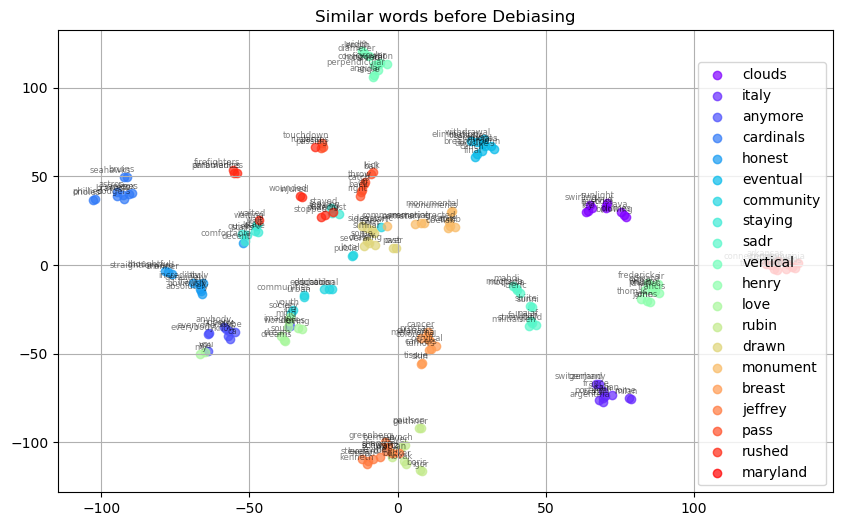

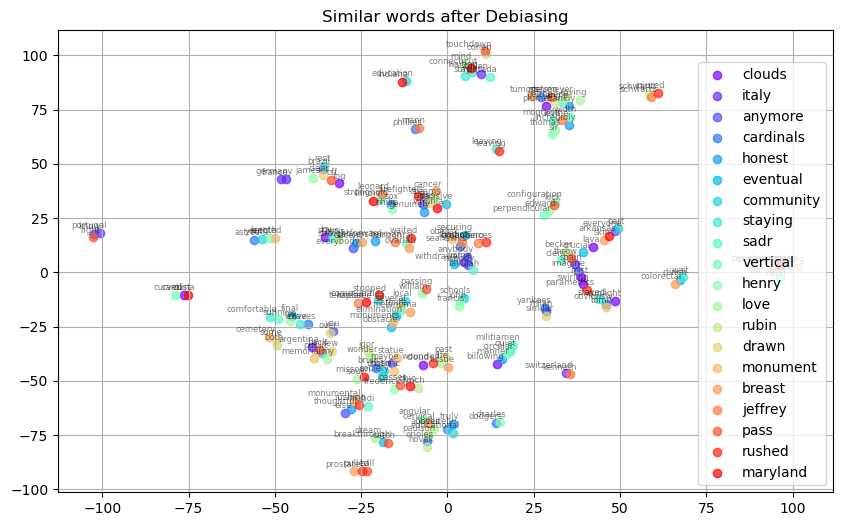

In [32]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [25]:
gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
                 # "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after=finding_neighbors_before_after(gendered_names, model_original, model_debiased, topn=3)

----------------------------------
word: ruth
 most-similar-before: ('joyce', 'ted', 'doris')
 most-similar-after: ('composer', 'threatening', 'greenspan')
----------------------------------
word: charlotte
 most-similar-before: ('portland', 'detroit', 'cleveland')
 most-similar-after: ('parallel', 'livewire', 'mischief')
----------------------------------
word: abigail
 most-similar-before: ('breslin', 'melanie', 'zachary')
 most-similar-after: ('playmate', 'payne', 'masquerading')
----------------------------------
word: sophie
 most-similar-before: ('kate', 'caroline', 'anna')
 most-similar-after: ('competes', 'runaway', 'graeme')
----------------------------------
word: nichole
 most-similar-before: ('nordeman', 'philipson', 'hotaling')
 most-similar-after: ('cranston', 'archway', 'stellation')
----------------------------------
word: emma
 most-similar-before: ('helen', 'julia', 'emily')
 most-similar-after: ('manipulated', 'barrow', 'reviewer')
----------------------------------


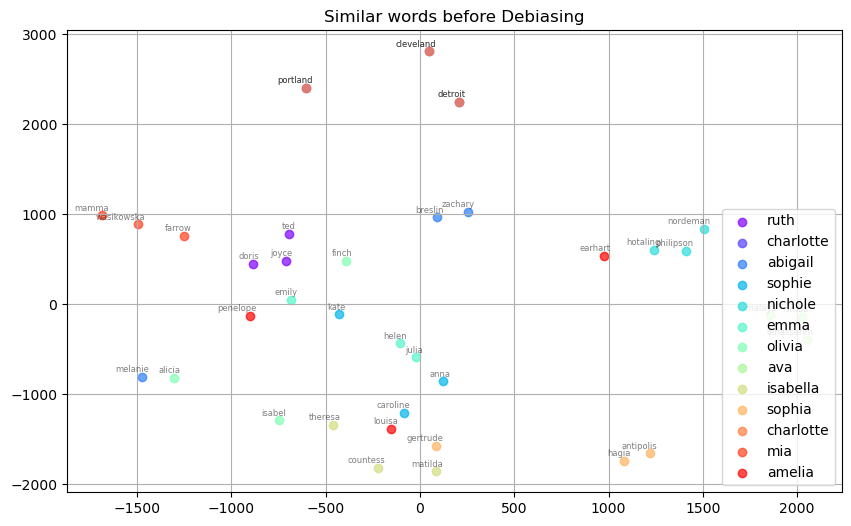

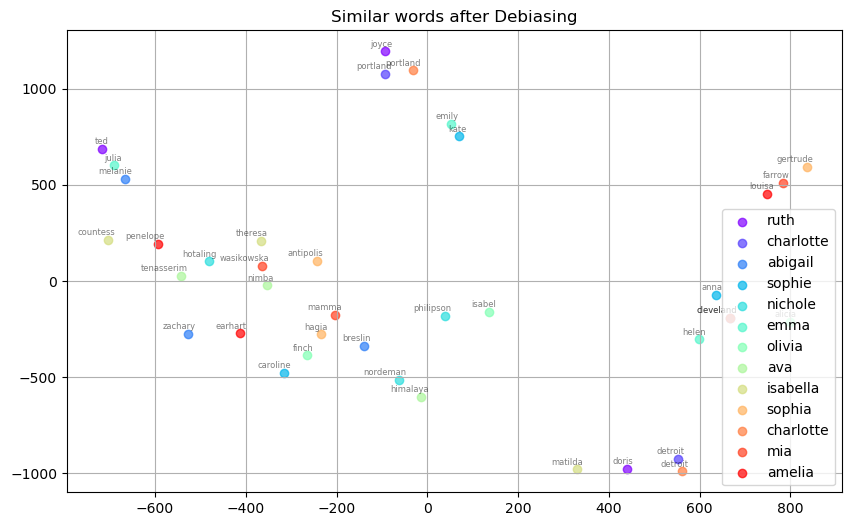

In [26]:
keys2=gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing', keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


### MAC Scores

In [ ]:
targets = [["he", "she"],
            ["his", "hers"],
            ["son", "daughter"],
            ["father", "mother"],
            ["male", "female"],
            ["boy", "girl"],
            ["uncle", "aunt"]]

Attribtutes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [ ]:
debiasedMAC, debiasedDistribution=multiclass_evaluation_MAC(
    debiased_dict, targets, Attribtutes)

originalMAC,originalDistribution = multiclass_evaluation_MAC(
    dict_vec_cleaned, targets, Attribtutes)


In [ ]:
from scipy.stats import ttest_rel, spearmanr
statistics, pvalue = ttest_rel(originalDistribution, debiasedDistribution)


### Bias by neighbor

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)


In [ ]:
biased_words=female_words+male_words

In [ ]:


k_neighbors=finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)


In [ ]:
#take k_neighbors dictionary and

In [ ]:
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)

### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

